# Neural Network From Scratch

## Import libraries

In [12]:
import numpy as np
import numpy as np
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt

## Installing and Setting up data

In [13]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pranavraikokte/covid19-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/mohamed/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2


In [14]:
def load_image_data(base_folder='train', image_size=(128, 128)):
    images = []
    labels = []
    class_names = sorted(os.listdir(base_folder))
    class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}

    print(f"Detected classes: {class_names}")

    for class_name in class_names:
        class_folder = os.path.join(base_folder, class_name)
        if not os.path.isdir(class_folder):
            continue

        print(f"Loading images from: {class_folder}")
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            try:
                with Image.open(img_path) as img:
                    img = img.resize(image_size)
                    img_array = np.array(img)

                    # Ensure images are consistent (e.g., convert grayscale to RGB if needed)
                    if img_array.ndim == 2:  # Grayscale image
                        img_array = np.stack([img_array, img_array, img_array], axis=-1)
                    elif img_array.ndim == 3 and img_array.shape[-1] == 4:  # RGBA image
                        img_array = img_array[..., :3]  # Discard alpha channel

                    images.append(img_array)
                    labels.append(class_to_idx[class_name])
            except Exception as e:
                print(f"Could not load image {img_path}: {e}")

    if not images:
        print("No images loaded. Please check your folder structure and image files.")
        return np.array([]), np.array([]), []

    images_np = np.array(images)
    labels_np = np.array(labels)

    # One-hot encode labels
    num_classes = len(class_names)
    labels_one_hot = np.eye(num_classes)[labels_np]

    return images_np, labels_one_hot, class_names




Detected classes: ['Covid', 'Normal', 'Viral Pneumonia']
Loading images from: ../data/Covid19-dataset/train/Covid
Loading images from: ../data/Covid19-dataset/train/Normal
Loading images from: ../data/Covid19-dataset/train/Viral Pneumonia

--- Data Loading Summary ---
Shape of image data (X_train): (251, 128, 128, 3)
Shape of label data (y_train): (251, 3)
Class labels: ['Covid', 'Normal', 'Viral Pneumonia']

First image shape: (128, 128, 3)
First image label (one-hot encoded): [1. 0. 0.]
First image actual class: Covid


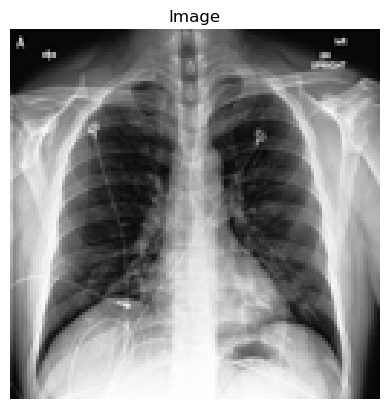

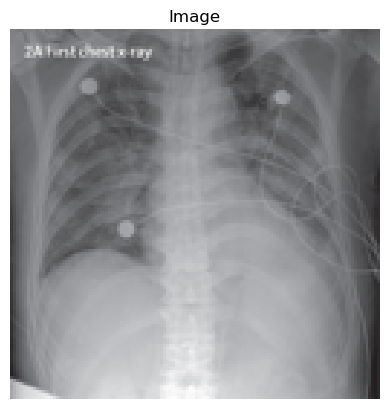

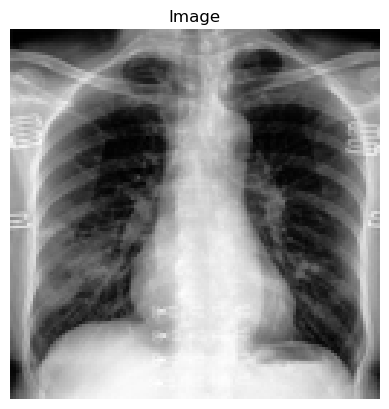

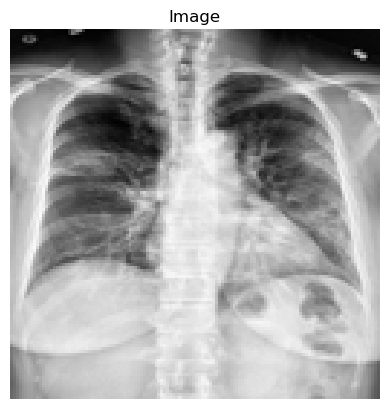

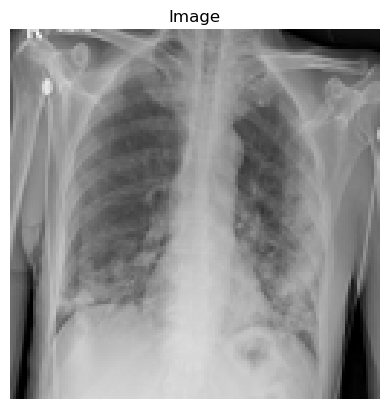

In [15]:
# Load the data

base_folder="../data/Covid19-dataset/train"

X_train, y_train, class_labels = load_image_data(base_folder, image_size=(128, 128))

print("\n--- Data Loading Summary ---")
print(f"Shape of image data (X_train): {X_train.shape}")
print(f"Shape of label data (y_train): {y_train.shape}")
print(f"Class labels: {class_labels}")

# You can now use X_train and y_train for your neural network training.
# For example, to see the first image and its label:
if X_train.size > 0:
    print(f"\nFirst image shape: {X_train[0].shape}")
    print(f"First image label (one-hot encoded): {y_train[0]}")
    # To get the actual class name of the first image:
    predicted_class_index = np.argmax(y_train[0])
    print(f"First image actual class: {class_labels[predicted_class_index]}")
    for i in range(5):
        plt.imshow(X_train[i])
        plt.title("Image")
        plt.axis('off') # Hide axes ticks and labels
        plt.show()
        

## Initialize the Neural Network

In [16]:
class NeuralNetwork:
    def _init_(self, input_size= 784, hidden_layers = [512,512], output_size=10):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.outputsize = output_size
        self.weights = []
        self.bias = []

        #Input to Hidden layers netowrk
        self.weights.append(0.01 * np.random.rand(input_size, hidden_layers[0]))
        self.bias.append(np.zeros((1, hidden_layers[0])))

        #Hidden layers network
        for i in range(len(hidden_layers)-1):
            self.weights.append(hidden_layers[i], hidden_layers[i+1])
            self.bias.append(np.zeros(1, hidden_layers[i+1]))
        
        #Hidden layers network to output
        self.weights.append(0.01 * np.random.rand(len(hidden_layers)-1, output_size))
        self.bias.append(np.zeros(1,output_size))


    def forward(self, inputs):
        layers = [inputs]
        for i in range(len(self.weights)):
            layers.append(np.dot(layers[-1],self.weights[i] + self.bias[i]))
        return layers[-1]


## Neural Network Functions

In [28]:
#Activation Function - Sigmoid Function
def sigmoid(x):
    return(1/(1 + np.exp(-x)))

#Feed Forward Neural Network
def feed_forward(x, w1, w2):
    x = x.reshape(1, -1)
    z1 = x.dot(w1)
    a1 = sigmoid(z1)
    z2 = a1.dot(w2)
    a2 = sigmoid(z2)
    return (a2)

#Weight initialization

def weight_int(x,y):
    li = []
    for i in range(x*y):
        li.append(np.random.rand())
    return np.array(li).reshape(x,y)

#Loss function - RMSE
def loss_function(out, Y):
    s =(np.square(out-Y))
    d = np.sum(s)/len(Y)
    v = np.sqrt(d)
    return (v)

def backpropagation(x, y, w1, w2, alpha):
    # Reshape x to a row vector
    x = x.reshape(1, -1)      # shape: (1, 49152)
    
    # Forward pass
    z1 = x.dot(w1)            # shape: (1, 30)
    a1 = sigmoid(z1)          # shape: (1, 30)
    z2 = a1.dot(w2)           # shape: (1, output_size)
    a2 = sigmoid(z2)          # shape: (1, output_size)

    # Error in output
    d2 = a2 - y.reshape(1, -1)           # shape: (1, output_size)
    d1 = np.multiply(d2.dot(w2.T), a1 * (1 - a1))  # shape: (1, 30)

    # Gradients
    w1_adj = x.T.dot(d1)     # (49152, 1) dot (1, 30) → (49152, 30)
    w2_adj = a1.T.dot(d2)    # (30, 1) dot (1, output_size) → (30, output_size)

    # Weight updates
    w1 = w1 - alpha * w1_adj
    w2 = w2 - alpha * w2_adj

    return w1, w2

## Initialize Weights

In [29]:
w1 = weight_int(49152, 30)
w2 = weight_int(30, 3)

print(w1, "\n\n", w2)

[[0.67153376 0.69037647 0.84963557 ... 0.76800773 0.53776572 0.9461101 ]
 [0.23460384 0.57171735 0.70728127 ... 0.02222381 0.69641669 0.55095661]
 [0.15944275 0.33346688 0.07521518 ... 0.87415814 0.03479151 0.30198945]
 ...
 [0.3529663  0.55141084 0.31901816 ... 0.03564958 0.72831088 0.62082052]
 [0.62809806 0.88656779 0.61237908 ... 0.60476197 0.65066154 0.77495917]
 [0.48702335 0.78774904 0.28179914 ... 0.09542914 0.58508211 0.10113322]] 

 [[0.81109692 0.55541819 0.08852685]
 [0.84438175 0.22428427 0.74569846]
 [0.38332201 0.28439394 0.40963575]
 [0.99974383 0.39223994 0.28681868]
 [0.32222507 0.49070691 0.69584285]
 [0.31015968 0.42907248 0.47499768]
 [0.75452764 0.88757187 0.84058665]
 [0.73806184 0.99260799 0.6534917 ]
 [0.45742779 0.05665847 0.47536907]
 [0.62989934 0.2643606  0.52174674]
 [0.65055338 0.37479202 0.96384312]
 [0.15291673 0.6567487  0.42579729]
 [0.68251696 0.62007436 0.91702941]
 [0.55429027 0.85419408 0.07880563]
 [0.48820564 0.05206891 0.64426031]
 [0.49134568 

## Train the Model

In [ ]:
def train(x, Y, w1, w2, alpha = 0.01, epoch = 10):
	acc =[]
	losss =[]
	for j in range(epoch):
		l =[]
		for i in range(len(x)):
			out = feed_forward(x[i], w1, w2)
			l.append((loss_function(out, Y[i])))
			w1, w2 = backpropagation(x[i], Y[i], w1, w2, alpha)
		print("epochs:", j + 1, "======== acc:", (1-(sum(l)/len(x)))*100) 
		acc.append((1-(sum(l)/len(x)))*100)
		losss.append(sum(l)/len(x))
	return(acc, losss, w1, w2)

X_train = X_train.reshape(len(X_train), -1)
acc, losss, w1, w2 = train(X_train, y_train, w1, w2, 0.1, 10)
print("Finished Training the Model.")

epochs: 1 ======== acc: 94.50212671398185
epochs: 2 ======== acc: 96.29047081413536
epochs: 3 ======== acc: 96.28899896747491
epochs: 4 ======== acc: 96.28899895993142
epochs: 5 ======== acc: 96.28899895993138
epochs: 6 ======== acc: 96.28899895993138
epochs: 7 ======== acc: 96.28899895993138
epochs: 8 ======== acc: 96.28899895993138
epochs: 9 ======== acc: 96.28899895993138
epochs: 10 ======== acc: 96.28899895993138
